# Perkenalan

`Rio Armiga - FTDS012`

Dataset : COVID Face Mask Detection Dataset
https://www.kaggle.com/datasets/prithwirajmitra/covid-face-mask-detection-dataset

`Problem Statements` 

Banyaknya karyawan yang tidak patuh protokol kesehatan ketika memasuki gedung kantor


`Objective`

Membuat model classification menggunakan deep learning untuk melakukan prediksi apakah karyawan menggunakan masker atau tidak.

# Download Dataset From Kaggle

In [ ]:
## hanya bisa dilakukan di google colab 
# ! pip install kaggle # Install kaggle di colab
# ! mkdir ~/.kaggle 
# ! cp kaggle.json ~/.kaggle/ 
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download -d prithwirajmitra/covid-face-mask-detection-dataset # download dataset
# ! unzip covid-face-mask-detection-dataset.zip # unzip dataset

# Import Library

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2
import tensorflow as tf

from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from google.colab import files

# Loading data

Inisialisasi data directory dan melihat class yang terdapat pada data

In [ ]:
data_dir = '/content/New Masks Dataset/Train/'
class_names=os.listdir(data_dir)
print(class_names)

['Mask', 'Non Mask']


Inisialisasi direktori dari train, test, dan validation data

In [ ]:
train_dir = '/content/New Masks Dataset/Train/'
test_dir = '/content/New Masks Dataset/Test/'
val_dir = '/content/New Masks Dataset/Validation/'

Inisialisasi direktori dari kelas mask dan no mask pada tiap data train, test, dan validation

In [ ]:

train_mask = glob.glob(train_dir+"/Mask/*")
train_nomask = glob.glob(train_dir+"/Non Mask/*")

test_mask = glob.glob(test_dir+"/Mask/*")
test_nomask = glob.glob(test_dir+"/Non Mask/*")

val_mask = glob.glob(val_dir+"/Mask/*")
val_nomask = glob.glob(val_dir+"/Non Mask/*")


Membuat list dari tiap kelas untuk dijadikan dataframe yang terdiri dari direktori dan kelas clasifikasinya

In [ ]:
train_list = [x for x in train_mask]
train_list.extend([x for x in train_nomask])

df_train = pd.DataFrame(np.concatenate([['Mask']*len(train_mask) , ['No Mask']*len(train_nomask)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_mask]
test_list.extend([x for x in test_nomask])

df_test = pd.DataFrame(np.concatenate([['Mask']*len(test_mask) , ['No Mask']*len(test_nomask)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

val_list = [x for x in val_mask]
val_list.extend([x for x in val_nomask])

df_val = pd.DataFrame(np.concatenate([['Mask']*len(val_mask) , ['No Mask']*len(val_nomask)]), columns = ['class'])
df_val['image'] = [x for x in val_list]

Dataframe train 

In [ ]:
df_train

,class,image
0,Mask,/content/New Masks Dataset/Train//Mask/1520.jpg
1,Mask,/content/New Masks Dataset/Train//Mask/1556.jpg
2,Mask,/content/New Masks Dataset/Train//Mask/1456.jpg
3,Mask,/content/New Masks Dataset/Train//Mask/1490.jpg
4,Mask,/content/New Masks Dataset/Train//Mask/1110.jpg
...,...,...
595,No Mask,/content/New Masks Dataset/Train//Non Mask/120...
596,No Mask,/content/New Masks Dataset/Train//Non Mask/218...
597,No Mask,/content/New Masks Dataset/Train//Non Mask/175...
598,No Mask,/content/New Masks Dataset/Train//Non Mask/164...


Dataframe test

In [ ]:
df_test

,class,image
0,Mask,/content/New Masks Dataset/Test//Mask/2265.png
1,Mask,/content/New Masks Dataset/Test//Mask/2159.png
2,Mask,/content/New Masks Dataset/Test//Mask/2264.png
3,Mask,/content/New Masks Dataset/Test//Mask/2132.jpg
4,Mask,/content/New Masks Dataset/Test//Mask/2179.png
...,...,...
95,No Mask,/content/New Masks Dataset/Test//Non Mask/real...
96,No Mask,/content/New Masks Dataset/Test//Non Mask/real...
97,No Mask,/content/New Masks Dataset/Test//Non Mask/real...
98,No Mask,/content/New Masks Dataset/Test//Non Mask/real...


Dataframe Validation

In [ ]:
df_val

,class,image
0,Mask,/content/New Masks Dataset/Validation//Mask/25...
1,Mask,/content/New Masks Dataset/Validation//Mask/64...
2,Mask,/content/New Masks Dataset/Validation//Mask/25...
3,Mask,/content/New Masks Dataset/Validation//Mask/24...
4,Mask,/content/New Masks Dataset/Validation//Mask/23...
...,...,...
301,No Mask,/content/New Masks Dataset/Validation//Non Mas...
302,No Mask,/content/New Masks Dataset/Validation//Non Mas...
303,No Mask,/content/New Masks Dataset/Validation//Non Mas...
304,No Mask,/content/New Masks Dataset/Validation//Non Mas...


# Exploratory Data Analysis (EDA)

Melihat jumlah file pada tiap dataframe

In [ ]:
print(f"Terdapat {len(df_train)} gambar pada train set")
print(f"Terdapat {len(df_test)} gambar pada test set")
print(f"Terdapat {len(df_val)} gambar pada validation set")

Terdapat 600 gambar pada train set
Terdapat 100 gambar pada test set
Terdapat 306 gambar pada validation set


Function untuk menunjukkan persentase pada grafik.

In [ ]:
def with_hue(ax, feature, Number_of_categories, hue_categories):
    a = [p.get_height() for p in ax.patches]
    patch = [p for p in ax.patches]
    for i in range(Number_of_categories):
        total = feature.value_counts().values[i]
        for j in range(hue_categories):
            percentage = '{:.1f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
            x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 2 - 0.15
            y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height() 
            ax.annotate(percentage, (x, y), size = 12)

def without_hue(ax, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)

Persentase kelas Mask dan No Mask

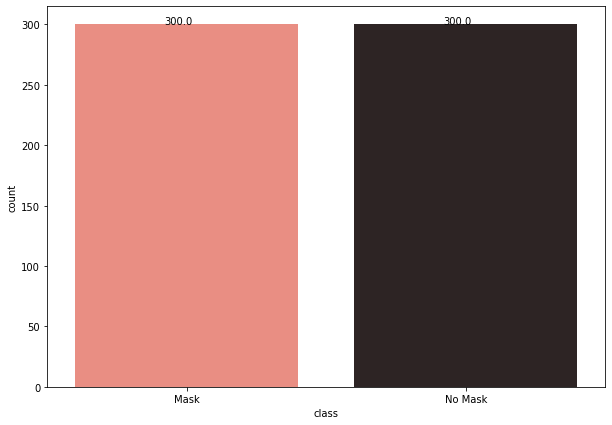

In [ ]:
plt.figure(figsize=(10,7))
ax= sns.countplot(data=df_train, x='class', palette='dark:salmon_r')
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.32, p.get_height()+0.6))

- Berdasarkan grafik perbandingan kelas pada dataframe train, jumlah keduanya sama dengan jumlah 300 file di tiap kelasnya.

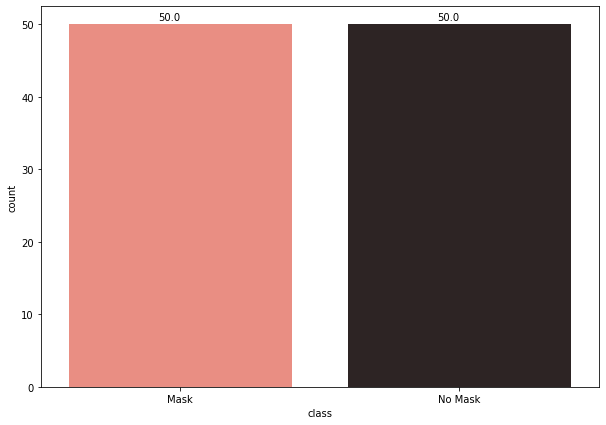

In [ ]:
plt.figure(figsize=(10,7))
ax= sns.countplot(data=df_test, x='class', palette='dark:salmon_r')
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.32, p.get_height()+0.6))

- Berdasarkan grafik perbandingan kelas pada dataframe test, jumlah keduanya sama dengan jumlah 50 file di tiap kelasnya.

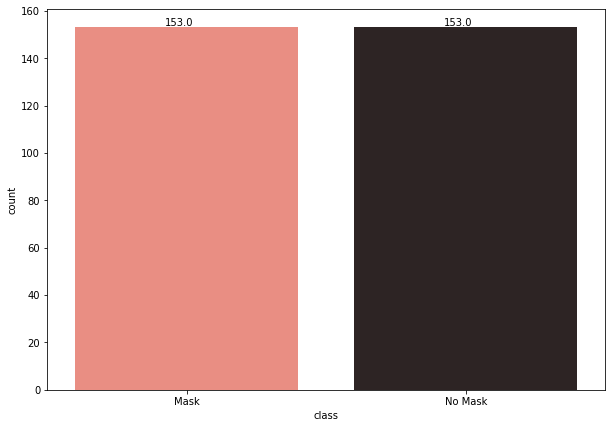

In [ ]:
plt.figure(figsize=(10,7))
ax= sns.countplot(data=df_val, x='class', palette='dark:salmon_r')
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.32, p.get_height()+0.6))

- Berdasarkan grafik perbandingan kelas pada dataframe validation, jumlah keduanya sama dengan jumlah 153 file di tiap kelasnya.

Melihat foto kelas mask yang terdapat pada train set

Train Set - With Mask


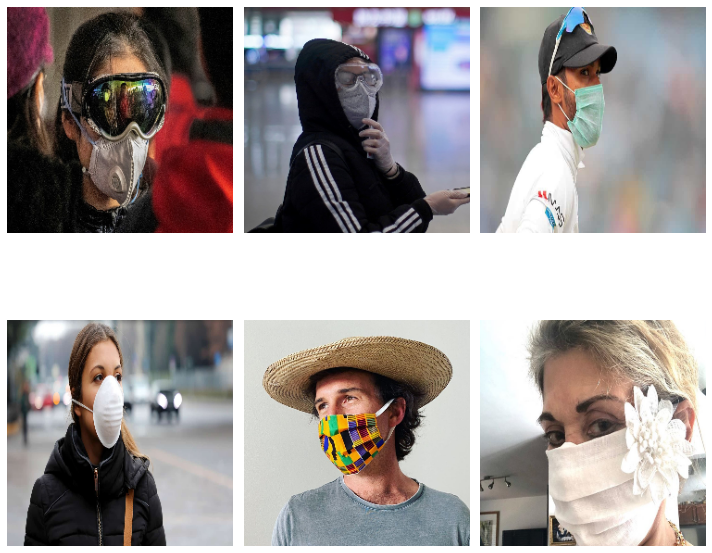

In [ ]:
print('Train Set - With Mask')

plt.figure(figsize=(10,10))

for i in range(0, 6):
    plt.subplot(2,3,i + 1)
    img = mpimg.imread(train_mask[i])
    img = cv2.resize(img, (244,244))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

Melihat foto kelas non mask yang terdapat pada train set

Train Set - Non Mask


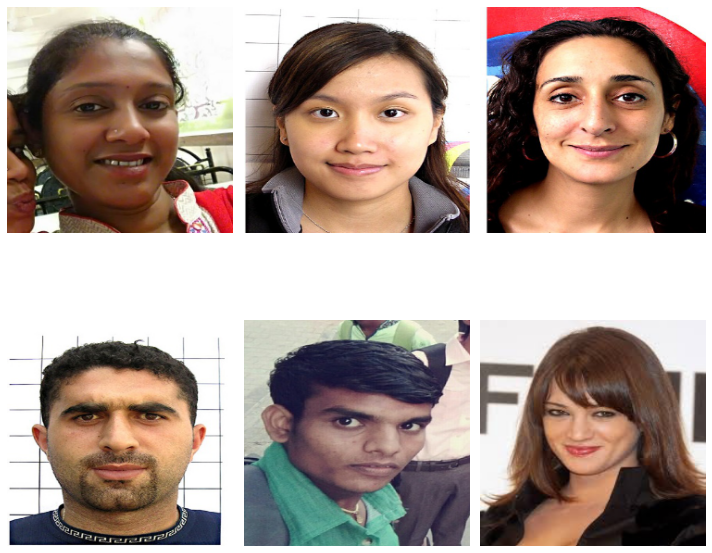

In [ ]:
print('Train Set - Non Mask')

plt.figure(figsize=(10,10))

for i in range(0, 6):
    plt.subplot(2,3,i + 1)
    img = mpimg.imread(train_nomask[i])
    img = cv2.resize(img, (244,244))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

Fungsi untuk memanggil gambar secara random dan kelasnya

In [ ]:
def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off");

    print(f"Image shape: {img.shape}")
    return img 

Image shape: (250, 226, 3)
Image shape: (2184, 1050, 3)
Image shape: (467, 700, 3)
Image shape: (480, 910, 3)
Image shape: (275, 183, 3)
Image shape: (768, 768, 3)
Image shape: (1024, 768, 3)
Image shape: (480, 910, 3)
Image shape: (600, 405, 3)
Image shape: (433, 650, 3)
Image shape: (467, 700, 3)
Image shape: (250, 226, 3)
Image shape: (250, 226, 3)


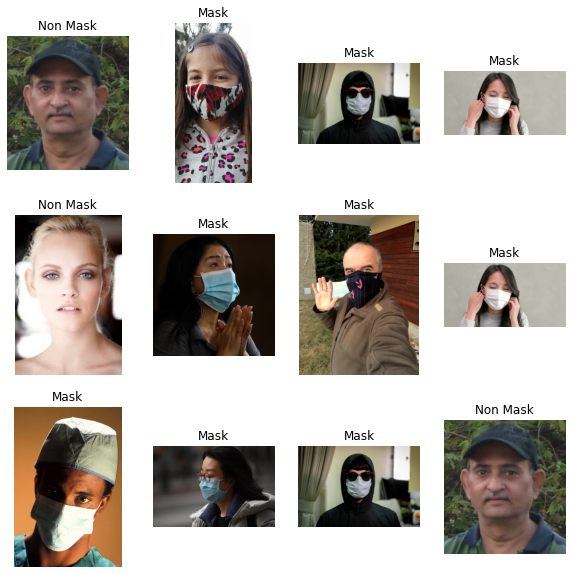

In [ ]:
import random
plt.figure(figsize=(10,10))
for i in range(12):
    plt.subplot(3,4,i+1)
    r=random.randint(0,1)
    img = view_random_image(data_dir, class_names[r])    
print(f"Image shape: {img.shape}")

# Input Data

Membuat variable train, validatio, dan test data.

In [ ]:
tf.random.set_seed(33)
train_data = image_dataset_from_directory(train_dir, 
                                        batch_size=32, 
                                        image_size=(224, 224),
                                        seed = 22)

valid_data = image_dataset_from_directory(val_dir, 
                                        batch_size=32, 
                                        image_size=(224, 224),
                                        seed = 22,
                                        shuffle=False)

test_data = image_dataset_from_directory(test_dir, 
                                        batch_size=32, 
                                        image_size=(224, 224),
                                        seed = 22,
                                        shuffle=False)


Found 600 files belonging to 2 classes.
Found 306 files belonging to 2 classes.
Found 100 files belonging to 2 classes.


Membuat fungsi untuk augmentasi data


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# membuat fungsi untuk augmentasi data
def aug_pipeline(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image, label

Membangun input pipeline, train, test dan validation

In [ ]:
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
train_data = train_data.map(aug_pipeline, num_parallel_calls=AUTOTUNE)

val_data = valid_data.cache().prefetch(buffer_size=AUTOTUNE)

test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# rescaling data agar berada pada rentang 0-1
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_data.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Modeling

## Creating Base Model 

Membuat model sequential dengan layer konfolusi dengan 16 neuron, layer maxpool dengan ukuran 2x2, layer flatten, hidden layer dengan 32 neuron dan output layer dengan activation sigmoid karena binary clasification. Model Compile menggunakan loss fuction binary crossentropy karena merupakan pasangan activation sigmoid karena model merupakan binary clasification, optimizer sgd, dan metrics accuracy

In [ ]:
# Buat model

#konvolusi 
model1 = Sequential(normalization_layer)
model1.add(Conv2D(16, 3, activation='relu', input_shape=(224, 224, 3)))
model1.add(MaxPool2D(2))

# Flatten
model1.add(Flatten())
model1.add(Dense(32, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

# Model compile
model1.compile(loss="binary_crossentropy",
              optimizer = 'sgd',
              metrics=['accuracy'])

Membangun fungsi callback agar model berhenti pada saat kenaikan accuracy dan penurunan loss yang sudah tidak signifikan.

In [ ]:
# mendefinisikan fungsi callback
callbacks= [EarlyStopping(monitor= 'val_loss', mode='min', patience= 6, verbose=1),
            ModelCheckpoint('bestmodel_47.hdf5', monitor='val_loss')]

Melakukan training model dengan epochs 40.

In [ ]:
# train model
training1 = model1.fit(train_data, 
                validation_data = val_data,
                callbacks = callbacks,
                epochs=40)

Epoch 1/40
19/19 [==============================] - 15s 382ms/step - loss: 0.7116 - accuracy: 0.5183 - val_loss: 0.6870 - val_accuracy: 0.5098
Epoch 2/40
19/19 [==============================] - 1s 71ms/step - loss: 0.6817 - accuracy: 0.5533 - val_loss: 0.6702 - val_accuracy: 0.5948
Epoch 3/40
19/19 [==============================] - 2s 85ms/step - loss: 0.6457 - accuracy: 0.6267 - val_loss: 0.6483 - val_accuracy: 0.6471
Epoch 4/40
19/19 [==============================] - 2s 78ms/step - loss: 0.6033 - accuracy: 0.6933 - val_loss: 0.6227 - val_accuracy: 0.6634
Epoch 5/40
19/19 [==============================] - 2s 76ms/step - loss: 0.5548 - accuracy: 0.7550 - val_loss: 0.6154 - val_accuracy: 0.6503
Epoch 6/40
19/19 [==============================] - 1s 70ms/step - loss: 0.5016 - accuracy: 0.7733 - val_loss: 0.6175 - val_accuracy: 0.6471
Epoch 7/40
19/19 [==============================] - 1s 75ms/step - loss: 0.4664 - accuracy: 0.7933 - val_loss: 0.5642 - val_accuracy: 0.7026
Epoch 8/40


training berhenti pada epoch 39

## Evaluating Base Model

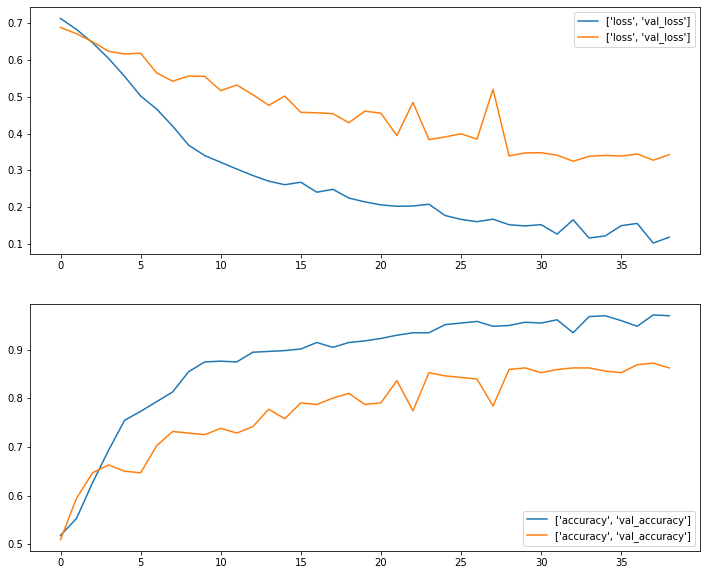

In [ ]:
plot = pd.DataFrame(training1.history)

fig, axs = plt.subplots(2, figsize=(12,10))
axs[0].plot(plot[['loss', 'val_loss']], label=['loss', 'val_loss'])
axs[0].legend(loc='upper right')
axs[1].plot(plot[['accuracy', 'val_accuracy']], label=['accuracy', 'val_accuracy'])
axs[1].legend(loc='lower right')

- Berdasarkan grafik perbandingan loss pada train data dan validation data pada model base, dapat dilihat loss pada percobaan terus menurun hingga 0.11, dan loss antara train data dan val data cenderung konvergen.
- Pada grafik perbandingan accurasi train data dan validation data pada model base, accuracy tertinggi berada pada angka 0.97. Model sudah cenderung baik jika ditinjau berdasrkan grafiknya.

Evaluasi dengan clasification report

In [ ]:
le = LabelEncoder()
y_test = le.fit_transform(df_test['class'])
y_pred1 = model1.predict(test_data)
y_pred1 = np.where(y_pred1 > 0.5, 1, 0)
print('Model Sequential')
print(classification_report(y_test, y_pred1))

Model Sequential
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        50
           1       0.88      0.86      0.87        50

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100



- Berdasarkan clasification report, prediksi yang dilakukan dengan data test, model bisa kita evaluasi dengan accuracy score karena data seimbang antar kelasnya. Accuracy dari base model mencapai 87%, angka tersebut sudah bagus tetapi masih ada ruang untuk dilakukan improvement

Evaluasi dengan confussion matrix

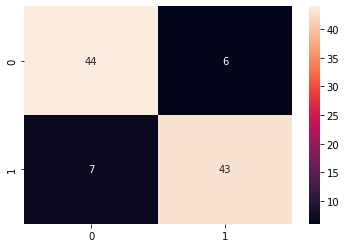

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred1)
sns.heatmap(cf_matrix, annot=True,fmt="d")

- Berdasarkan confusion matrix, 44 orang berhasil diprediksi sebagai kelas 0 (TN) dan 6 orang gagal diprediksi sebagai kelas 0 (FP), 43 orang berhasil diprediksi sebagai kelas 1 (TP) dan 7 orang gagal diprediksi sebagai kelas 1 (FN).

## Creating Model Improvement

Membuat imrpovement dengan model sequential dengan 4 layer konfolusi, masing masing dengan 16,32, 128, dan 256 neuron, 4 layer maxpool dengan ukuran 2x2, 4 layer batchnormalization, layer flatten, hidden layer dengan 32 neuron dan output layer dengan activation sigmoid karena binary clasification. Model Compile menggunakan loss fuction binary crossentropy karena merupakan pasangan activation sigmoid karena model merupakan binary clasification, optimizer Adamax, dengan metrics accuracy.

In [ ]:
model2 = Sequential()
model2.add(Conv2D(16, 3, activation='relu', input_shape=(224, 224, 3)))
model2.add(MaxPool2D(2))

model2.add(Conv2D(32, 3, activation='relu'))
model2.add(MaxPool2D(2))
model2.add(BatchNormalization())

model2.add(Conv2D(128, 3, activation='relu'))
model2.add(MaxPool2D(2))
model2.add(BatchNormalization())

model2.add(Conv2D(256, 3, activation='relu'))
model2.add(MaxPool2D(2))
model2.add(BatchNormalization())


# Flatten
model2.add(Flatten())
model2.add(Dense(32, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

# Model compile
model2.compile(loss="binary_crossentropy",
              optimizer = 'adamax',
              metrics=['accuracy'])


Melakukan training dengan epoch 70

In [ ]:
# train model
training2 = model2.fit(train_data, 
                validation_data = val_data,
                callbacks = callbacks,
                epochs=70)

Epoch 1/70
19/19 [==============================] - 3s 105ms/step - loss: 0.9750 - accuracy: 0.8350 - val_loss: 10.3104 - val_accuracy: 0.5098
Epoch 2/70
19/19 [==============================] - 1s 56ms/step - loss: 0.3000 - accuracy: 0.9200 - val_loss: 10.3377 - val_accuracy: 0.5098
Epoch 3/70
19/19 [==============================] - 1s 57ms/step - loss: 0.1472 - accuracy: 0.9517 - val_loss: 0.6670 - val_accuracy: 0.8791
Epoch 4/70
19/19 [==============================] - 1s 58ms/step - loss: 0.0399 - accuracy: 0.9850 - val_loss: 0.6172 - val_accuracy: 0.8791
Epoch 5/70
19/19 [==============================] - 2s 95ms/step - loss: 0.0263 - accuracy: 0.9900 - val_loss: 0.6150 - val_accuracy: 0.8693
Epoch 6/70
19/19 [==============================] - 2s 88ms/step - loss: 0.0155 - accuracy: 0.9933 - val_loss: 0.5626 - val_accuracy: 0.8922
Epoch 7/70
19/19 [==============================] - 2s 75ms/step - loss: 0.0065 - accuracy: 0.9967 - val_loss: 0.5542 - val_accuracy: 0.8889
Epoch 8/70

training berhenti pada epoch ke 13

## Evaluating Improved Model

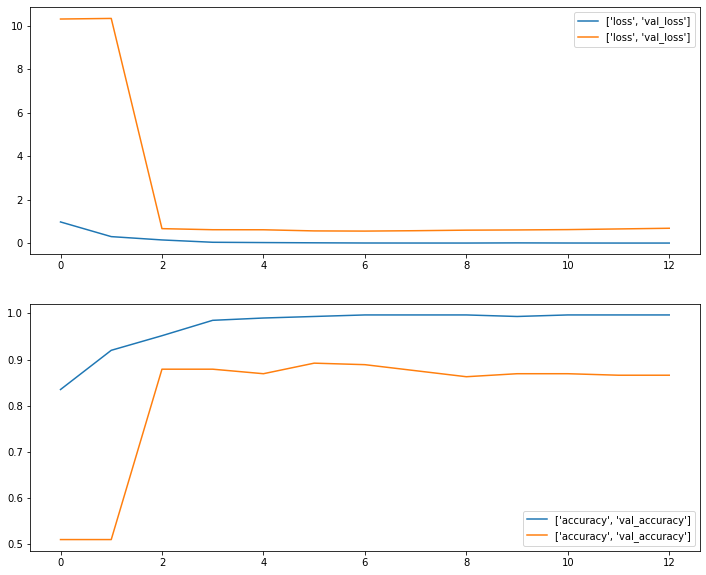

In [ ]:
plot_imp = pd.DataFrame(training2.history)

fig, axs = plt.subplots(2, figsize=(12,10))
axs[0].plot(plot_imp[['loss', 'val_loss']], label=['loss', 'val_loss'])
axs[0].legend(loc='upper right')
axs[1].plot(plot_imp[['accuracy', 'val_accuracy']], label=['accuracy', 'val_accuracy'])
axs[1].legend(loc='lower right')

- Berdasarkan grafik perbandingan loss pada train data dan validation data pada model improved, dapat dilihat loss pada percobaan terus menurun hingga 0.0037, dan valiation loss sebesar 0.68. loss antara train data dan val data cenderung konvergen.
- Pada grafik perbandingan accurasi train data dan validation data pada model improved, accuracy tertinggi berada pada angka 0.9967. Model sudah cenderung baik jika ditinjau berdasrkan grafiknya.

In [ ]:
y_pred2 = model2.predict(test_data)
y_pred2 = np.where(y_pred2 > 0.5, 1, 0)
print('Model Sequential')
print(classification_report(y_test, y_pred2))

Model Sequential
              precision    recall  f1-score   support

           0       1.00      0.88      0.94        50
           1       0.89      1.00      0.94        50

    accuracy                           0.94       100
   macro avg       0.95      0.94      0.94       100
weighted avg       0.95      0.94      0.94       100



- Berdasarkan clasification report, prediksi yang dilakukan dengan data test, Accuracy dari improved model mencapai 94%, angka tersebut sudah meningkat dari base model yang mendapatkan Accuracy sebesar 87%.

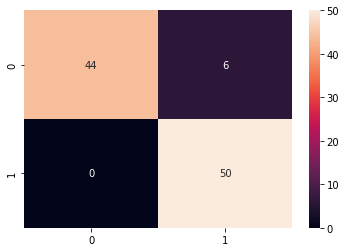

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred2)
sns.heatmap(cf_matrix, annot=True,fmt="d")

- Berdasarkan confusion matrix, 44 orang berhasil diprediksi sebagai kelas 0 (TN) dan 6 orang gagal diprediksi sebagai kelas 0 (FP), 50 orang berhasil diprediksi sebagai kelas 1 (TP) dan tidak ada yang gagal diprediksi sebagai kelas 1 (FN). Model sudah lebih baik dari base model dalam memprediksi kelas.

ROC_AUC:  0.94


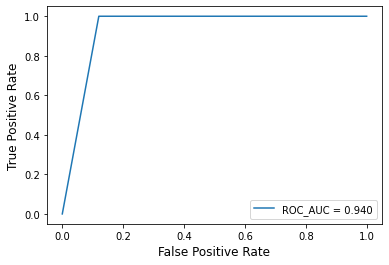

In [ ]:
roc_auc =roc_auc_score(y_test, y_pred2)
print('ROC_AUC: ', roc_auc)

fpr, tpr, thresholds =roc_curve(y_test, y_pred2)

plt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)
plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

- Berdasarkan ROC AUC dapat dilihat model sudah baik dalam memisahkan kelas 0 dan kelas 1 dengan score 0.94

In [61]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]

    return predicted_class

Menampilkan foto yang berhasil dideteksi oleh model

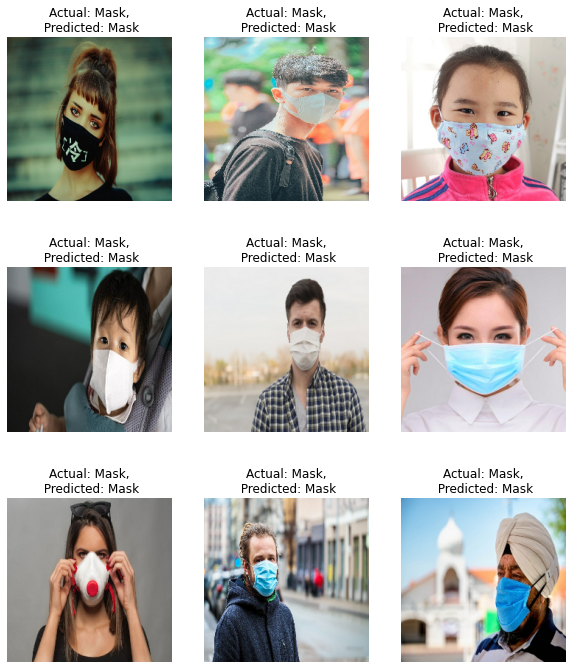

In [63]:
plt.figure(figsize=(10, 12))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class = predict(model2, images[i].numpy())

        actual_class = class_names[np.argmin(labels[i])] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}")
        
        plt.axis("off")

Berdasarkan foto di atas, semua foto berhasil diprediksi dengan baik oleh model.

# Model Saving

Melakukan model saving agar bisa dilakuakan depoyment model di website.

In [ ]:
# freeze model
model2.trainable = False

In [ ]:
model2.save("mask.h5")

In [ ]:
inference_model = tf.keras.models.load_model('mask.h5')
inference_model.save("inference_mask")

INFO:tensorflow:Assets written to: inference_mask/assets


# Model Inference

Melakukan testing dengan data baru pada model.

Saving 24.jpg to 24.jpg


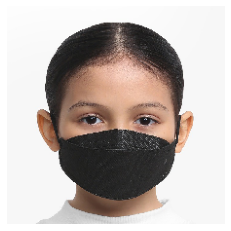

[[0.9992913]]
Mask detected, you can enter


In [74]:
# hanya bisa dilakukan di google colab
from tensorflow.keras.preprocessing import image # Import library dilakukan di sini karena jika di import di atas terjadi error

uploaded = files.upload() # permintaan upload gambar 

for fn in uploaded.keys():
 
  # Prediksi dengan mengunggah gambar
  path = fn
  img = image.load_img(path, target_size=(224,224))  # seusai input pada model
  plt.imshow(img)
  plt.axis('Off')
  plt.show()
  x = image.img_to_array(img) # untuk ubah image kedalam array
  x = np.expand_dims(x, axis=0) 

  images = np.vstack([x])
  classes = inference_model.predict(images) #gunakan model yang terbaik misal yg variable my_model untuk predict images
  print(classes) 
  if classes >= 0.5:
    print('Mask detected, you can enter')
  else:
    print('Mask not detected. Sorry, you have to wear your mask to enter')

# Kesimpulan

- Berdasarkan grafik perbandingan kelas pada dataframe train, jumlah keduanya sama dengan jumlah 300 file di tiap kelasnya, pada dataframe test terdapat 50 file di tiap kelasnya dan pada dataframe validation terdapat 153 file di tiap kelasnya
- Membuat model sequential dengan layer konfolusi dengan 16 neuron, layer maxpool dengan ukuran 2x2, layer flatten, hidden layer dengan 32 neuron dan output layer dengan activation sigmoid karena binary clasification. Model Compile menggunakan loss fuction binary crossentropy karena merupakan pasangan activation sigmoid karena model merupakan binary clasification, optimizer sgd, dan metrics accuracy
- Membangun fungsi callback agar model berhenti pada saat kenaikan accuracy dan penurunan loss yang sudah tidak signifikan.
- Melakukan training model dengan epochs 40 dan training berhenti pada epoch 39
- Berdasarkan grafik perbandingan loss pada train data dan validation data pada model base, dapat dilihat loss pada percobaan terus menurun hingga 0.11, dan loss antara train data dan val data cenderung konvergen.
- Pada grafik perbandingan accurasi train data dan validation data pada model base, accuracy tertinggi berada pada angka 0.97. Model sudah cenderung baik jika ditinjau berdasrkan grafiknya.
- Berdasarkan clasification report, prediksi yang dilakukan dengan data test, model bisa kita evaluasi dengan accuracy score karena data seimbang antar kelasnya. Accuracy dari base model mencapai 87%, angka tersebut sudah bagus tetapi masih ada ruang untuk dilakukan improvement
- Berdasarkan confusion matrix, 44 orang berhasil diprediksi sebagai kelas 0 (TN) dan 6 orang gagal diprediksi sebagai kelas 0 (FP), 43 orang berhasil diprediksi sebagai kelas 1 (TP) dan 7 orang gagal diprediksi sebagai kelas 1 (FN).
- Membuat imrpovement dengan model sequential dengan 4 layer konfolusi, masing masing dengan 16,32, 128, dan 256 neuron, 4 layer maxpool dengan ukuran 2x2, 4 layer batchnormalization, layer flatten, hidden layer dengan 32 neuron dan output layer dengan activation sigmoid karena binary clasification. Model Compile menggunakan loss fuction binary crossentropy karena merupakan pasangan activation sigmoid karena model merupakan binary clasification, optimizer Adamax, dengan metrics accuracy.
- Melakukan training dengan epoch 70 dan training berhenti pada epoch ke 13
- Berdasarkan grafik perbandingan loss pada train data dan validation data pada model improved, dapat dilihat loss pada percobaan terus menurun hingga 0.0037, dan valiation loss sebesar 0.68. loss antara train data dan val data cenderung konvergen.
- Pada grafik perbandingan accurasi train data dan validation data pada model improved, accuracy tertinggi berada pada angka 0.9967. Model sudah cenderung baik jika ditinjau berdasrkan grafiknya.
- Berdasarkan clasification report, prediksi yang dilakukan dengan data test, Accuracy dari improved model mencapai 94%, angka tersebut sudah meningkat dari base model yang mendapatkan Accuracy sebesar 87%.
- Berdasarkan confusion matrix, 44 orang berhasil diprediksi sebagai kelas 0 (TN) dan 6 orang gagal diprediksi sebagai kelas 0 (FP), 50 orang berhasil diprediksi sebagai kelas 1 (TP) dan tidak ada yang gagal diprediksi sebagai kelas 1 (FN). Model sudah lebih baik dari base model dalam memprediksi kelas.
- Berdasarkan ROC AUC dapat dilihat model sudah baik dalam memisahkan kelas 0 dan kelas 1 dengan score 0.94
- Model clasification berhasil dibangun dan bisa di implementasikan pada pintu masuk kantor, model bisa dikombinasikan dengan sistem keamanan kantor, jika karyawan tidak memakai masker, ketika melakukan tap id card tidak akan diberikan akses.